<a href="https://colab.research.google.com/github/sunflowerseed17/PythonDSProject/blob/main/Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and Loading

In [66]:
'''
Installing modules, packages and dependencies
'''
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud

In [67]:
# Load Folders containing preprocessed posts
# Folders containing preprocessed posts
folders = {
    "depression": {
        "path": "preprocessed_depression_posts",
        "label": 1  # Label for depression-related posts
    },
    "breastcancer": {
        "path": "preprocessed_breastcancer_posts",
        "label": 0  # Label for breast cancer posts
    }
}

## N-Grams

In [68]:

# Initialize TfidfVectorizer with unigrams and bigrams
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(documents)

# Get the feature names (unigrams and bigrams)
feature_names = vectorizer.get_feature_names_out()
print(f"Number of features (unigrams + bigrams): {len(feature_names)}")


Number of features (unigrams + bigrams): 34004


### Unigrams and Bigrams used to capture context (unigrams = single words, bigrams = pairs of words)

In [69]:
# Get feature names and the sum of TF-IDF scores across all documents
feature_names = vectorizer.get_feature_names_out()
tfidf_sums = np.array(tfidf_matrix.sum(axis=0)).flatten()

# Get indices of the top N most common features
top_n = 10  # Adjust to how many common features you want to see
top_indices = np.argsort(tfidf_sums)[-top_n:]  # Indices of top features

# Print the most common features
print(f"Top {top_n} Most Common Features:")
for i in reversed(top_indices):
    print(f"{feature_names[i]}: {tfidf_sums[i]:.4f}")


Top 10 Most Common Features:
feel: 11.5934
like: 10.1414
want: 7.9089
know: 7.1845
year: 6.7375
life: 6.4961
time: 6.0988
feel like: 5.7449
realli: 5.6628
thing: 5.3286


### Extract TF-IDF features, train a logistic regression model with hyperparameter tuning, and identify key features for each category.

In [71]:
# Collect documents and labels from both categories
documents = []
labels = []

for category, info in folders.items():
    file_paths = glob.glob(f"{info['path']}/*.txt")
    for file_path in file_paths:
        with open(file_path, "r", encoding="utf-8") as file:
            content = file.read().strip()  # Remove extra whitespace
            if content:
                documents.append(content)
                labels.append(info["label"])  # Assign the corresponding label

# Debugging: Check documents and labels
print(f"Number of valid documents: {len(documents)}")
if documents:
    print(f"Sample document (label {labels[0]}): {documents[0]}")

# Initialize TfidfVectorizer with unigrams and bigrams
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf_matrix = vectorizer.fit_transform(documents)

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # L1 is not supported by LogisticRegression with liblinear solver
    'solver': ['liblinear']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=500), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("\nBest Hyperparameters:")
print(grid_search.best_params_)

# Train the best Logistic Regression model
classifier = grid_search.best_estimator_
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Get feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = classifier.coef_[0]  # No need to call .toarray() since coef_ is already a numpy array

# Get top 10 positive and negative features
top_positive_indices = np.argsort(coefficients)[-10:]  # Largest coefficients
top_negative_indices = np.argsort(coefficients)[:10]   # Smallest coefficients

print("\nTop 10 Positive Features (indicating depression):")
for i in reversed(top_positive_indices):
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")

print("\nTop 10 Negative Features (indicating breast cancer):")
for i in top_negative_indices:
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")

Number of valid documents: 293
Sample document (label 1): think feel express see firework shoot sky explod countdown reach 1 everyon shout happi new year sure know common express peopl show happi excit 2025 like hand look sky fill firework awe hit everyon shout happi new year anoth year surviv hell huh thought multipl dozen differ kind firework shot sky felt magic mystic yet one feel get year turn 2024 2025 felt pain recal pain child first time felt pain made angri sad resent made angri sad stori goe long stori never fit peer sinc 8 figur differ breed one understood uniqu tast topic interest idea shun group activ even talk behind back thu shut world decid live world comfort basic shut becom introvert mostli stay home intent make friend offlin call love anim much brought joy happi real peopl never give judg harm mental verbal could say pretti much long 16 graduat secondari school want chang look mirror first time life saw piec sh like hate new year came went colleg farther away secondar

### Visualize features from logistic regression model (bar plots and word clouds)




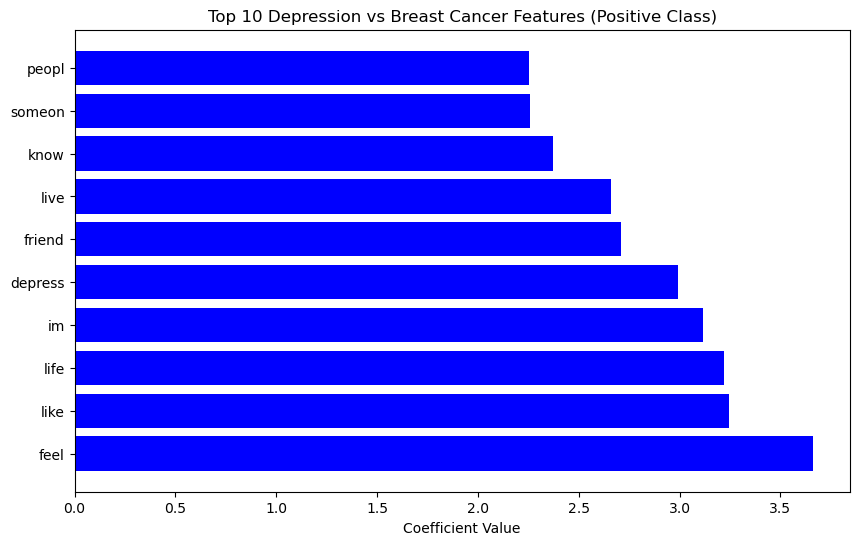

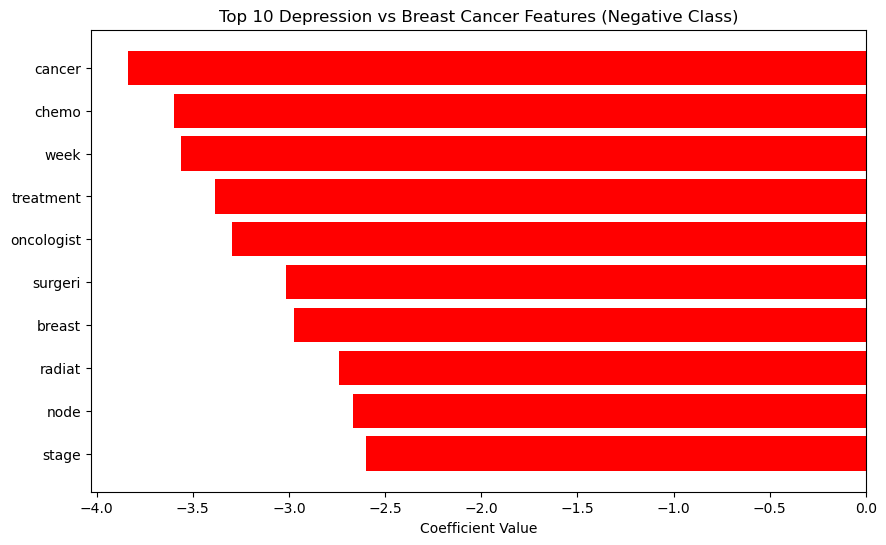

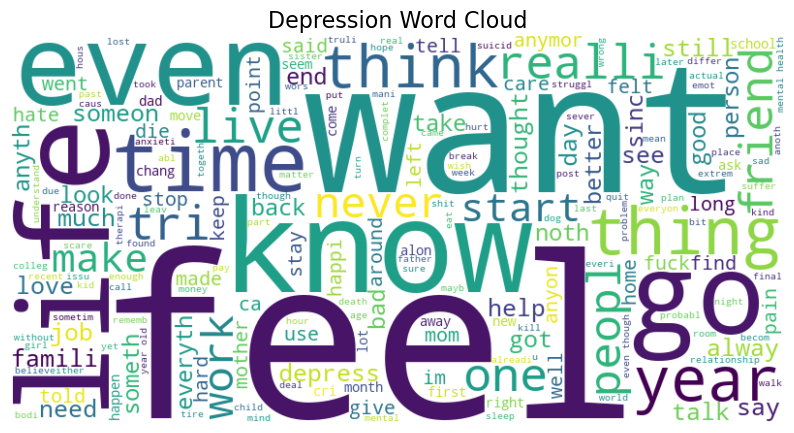

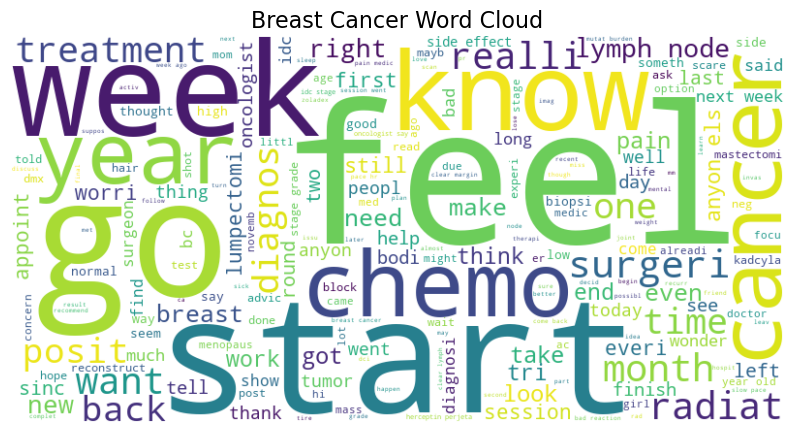

In [72]:

def visualize_features(feature_names, coefficients, title, top_n=10):
    sorted_indices = np.argsort(coefficients)
    top_features = [(feature_names[i], coefficients[i]) for i in sorted_indices[-top_n:]]
    bottom_features = [(feature_names[i], coefficients[i]) for i in sorted_indices[:top_n]]
    
    top_features.reverse()  # Largest first
    bottom_features.reverse()  # Smallest first
    
    # Plot positive features
    plt.figure(figsize=(10, 6))
    plt.barh([f[0] for f in top_features], [f[1] for f in top_features], color='blue')
    plt.xlabel("Coefficient Value")
    plt.title(f"Top {top_n} {title} Features (Positive Class)")
    plt.show()
    
    # Plot negative features
    plt.figure(figsize=(10, 6))
    plt.barh([f[0] for f in bottom_features], [f[1] for f in bottom_features], color='red')
    plt.xlabel("Coefficient Value")
    plt.title(f"Top {top_n} {title} Features (Negative Class)")
    plt.show()

visualize_features(feature_names, coefficients, "Depression vs Breast Cancer", top_n=10)

# Generate Word Clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Combine all depression and breast cancer documents
depression_text = " ".join([documents[i] for i in range(len(labels)) if labels[i] == 1])
breast_cancer_text = " ".join([documents[i] for i in range(len(labels)) if labels[i] == 0])

generate_wordcloud(depression_text, "Depression Word Cloud")
generate_wordcloud(breast_cancer_text, "Breast Cancer Word Cloud")


## TODO: Empath instead of the LIWC

In [73]:
'''
Installing modules, packages and dependencies
'''
import json
from collections import Counter
!pip install empath
from empath import Empath

     --------------------------------------- 57.6/57.6 kB 58.3 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57807 sha256=dc870b3f45814aefb25c8fc5cc2cdce827e6daf73701036ca0e6f358a547c97c
  Stored in directory: c:\users\jgber\appdata\local\pip\cache\wheels\3b\91\4d\fc3e9e2e72bc09406bfccfc8bfbaa31452eeb67cad5ef22e93
Successfully built empath


In [74]:
'''
Initialising the Empath model
'''
lexicon = Empath()

In [75]:
'''
Extracting features
'''
def extract_empath_features(text, lexicon):
    analysis = lexicon.analyze(text, normalize=True)
    return analysis

In [76]:
'''
Extracting features for each document
'''
empath_features = [extract_empath_features(doc, lexicon) for doc in documents]

In [77]:
'''
Printing the features for each document
'''
for i, features in enumerate(empath_features):
    print(f"Document {i+1} Features:\n", features)

Document 1 Features:
 {'help': 0.001349527665317139, 'office': 0.0, 'dance': 0.001349527665317139, 'money': 0.001349527665317139, 'wedding': 0.001349527665317139, 'domestic_work': 0.004048582995951417, 'sleep': 0.004048582995951417, 'medical_emergency': 0.001349527665317139, 'cold': 0.004048582995951417, 'hate': 0.008097165991902834, 'cheerfulness': 0.001349527665317139, 'aggression': 0.001349527665317139, 'occupation': 0.0, 'envy': 0.006747638326585695, 'anticipation': 0.001349527665317139, 'family': 0.009446693657219974, 'vacation': 0.006747638326585695, 'crime': 0.001349527665317139, 'attractive': 0.004048582995951417, 'masculine': 0.004048582995951417, 'prison': 0.001349527665317139, 'health': 0.005398110661268556, 'pride': 0.002699055330634278, 'dispute': 0.005398110661268556, 'nervousness': 0.005398110661268556, 'government': 0.001349527665317139, 'weakness': 0.0, 'horror': 0.014844804318488529, 'swearing_terms': 0.002699055330634278, 'leisure': 0.005398110661268556, 'suffering':



Extract 68 features from LIWC, focusing of categories of Psychological Processes, Linguistic Dimensions, Personal Concerns.

## TODO: Topic Modelling using LDA (Latent Dirichlet Allocation)

### Use the Mallet toolkit or Gensim library in Python to apply LDA

In [78]:
import mallet
import gensim

ModuleNotFoundError: No module named 'mallet'